<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-2/2-colab-what-does-my-neural-network-think.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-2/2-colab-what-does-my-neural-network-think.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This code is part of [Chapter 2 - What’s in the Picture: Image Classification with Keras](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch02.html). This is a Colab-specific version. To run on Jupyter locally, please run <a target="_blank" href="c">chapter-2/2-what-does-my-neural-network-think.ipynb</a> instead.

# What Does My Neural Network Think?

In this code sample, we try to understand why the neural network made a particular prediction. We use visualization (a heatmap) to understand the decision-making that is going on within the network. Using color, we visually identify the areas within an image that prompted a decision. “Hot” spots, represented by warmer colors (red, orange, and yellow) highlight the areas with the maximum signal, whereas cooler colors (blue, purple) indicate low signal.

In [14]:
# Perform all installations
!pip install tensorflow-gpu==2.0.0
!pip install tf-explain==0.1.0

In [15]:
import tensorflow as tf
import numpy as np

#Get TensorBoard to run
%load_ext tensorboard

We can add multiple types of callbacks while training or use its core API to generate TensorFlow events that can later be loaded into TensorBoard. 

In [16]:
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.activations import ExtractActivations

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

For inference, all we need to do is pass an image, its ImageNet object ID along with a model into tf-explain’s functions. The object id is needed as tf.explain needs to figure out what is activated for that particular class.

In [17]:
try:
  import google.colab
  IS_COLAB_ENV = True
except:
  IS_COLAB_ENV = False

In [18]:
def download_sample_image(filename):
    import requests
    url = f'https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/{filename}'
    open(filename, 'wb').write(requests.get(url).content)

In [19]:
if IS_COLAB_ENV:
    IMAGE_PATHS = ['dog.jpg', 'cat.jpg']
    for each_filename in IMAGE_PATHS:
        download_sample_image(each_filename)
else:
    IMAGE_PATHS = [ '../../sample-images/dog.jpg', '../../sample-images/cat.jpg']

In [24]:
def display_images(paths):
  # figure size in inches optional
  rcParams['figure.figsize'] = 11 ,8
  
  # read images
  img_A = mpimg.imread(paths[0])
  img_B = mpimg.imread(paths[-1])
  
  # display images
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(img_A);
  ax[1].imshow(img_B);

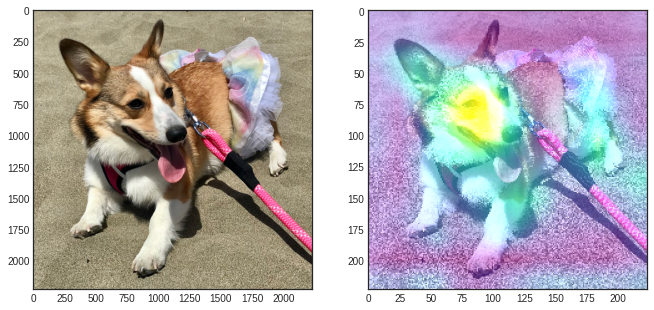

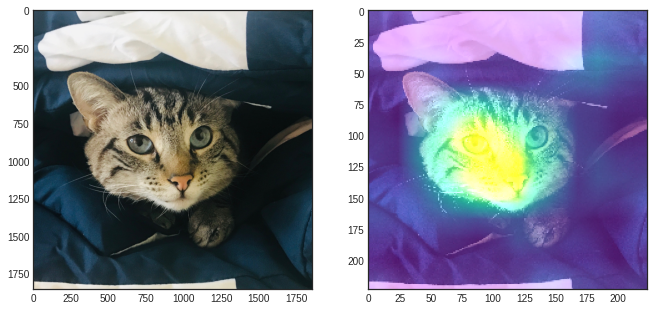

In [25]:
indices = [263, 281]

layers_name = ['activation_6']

from IPython.display import Image

for i in range(len(IMAGE_PATHS)):
    each_path = IMAGE_PATHS[i]
    index = indices[i]

    img = tf.keras.preprocessing.image.load_img(each_path,
                                                target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    data = ([img], None)
    # Define name with which to save the result as
    name = each_path.split("/")[-1].split(".jpg")[0]

    #Save the Grad Cam visualization
    explainer = GradCAM()
    model = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                              include_top=True)
    grid = explainer.explain(data, model, 'block5_conv3', index)
    explainer.save(grid, '.', name + 'grad_cam.png')
    display_images([each_path, name + 'grad_cam.png'])